In [2]:
import tensorflow as tf
import numpy as np
import yaml
import logging
import os
from pathlib import Path
from datetime import datetime
from model import Generator  # Assuming this is a custom U-Net model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

class SegmentationTrainer:
    """A class to handle training of a U-Net model for multi-class segmentation."""

    def __init__(self, config_path: str):
        """
        Initialize the trainer with configuration from a YAML file.

        Args:
            config_path (str): Path to the YAML configuration file.
        """
        if not os.path.exists(config_path):
            logger.error(f"Configuration file not found at {config_path}")
            raise FileNotFoundError(f"Configuration file not found at {config_path}")
        self.config = self._load_config(config_path)
        self._validate_config()
        self.data_path = Path(self.config['data']['path'])
        self.model = None
        self.train_dataset = None
        self.val_dataset = None
        self.setup_environment()

    def _load_config(self, config_path: str) -> dict:
        """Load and parse the YAML configuration file."""
        try:
            with open(config_path, 'r') as file:
                config = yaml.safe_load(file)
            logger.info(f"Loaded configuration from {config_path}")
            return config
        except Exception as e:
            logger.error(f"Failed to load config file {config_path}: {str(e)}")
            raise

    def _validate_config(self):
        """Validate the configuration parameters."""
        required_keys = [
            'data.path', 'data.buffer_size', 'data.batch_size',
            'model.img_width', 'model.img_height', 'model.input_channels', 'model.output_channels',
            'training.epochs', 'training.batch_size', 'training.weights_path',
            'training.checkpoint_dir', 'training.alpha'
        ]
        for key in required_keys:
            if not self._get_nested_config(key):
                logger.error(f"Missing or invalid configuration key: {key}")
                raise ValueError(f"Configuration key {key} is missing or invalid")

    def _get_nested_config(self, key: str):
        """Access nested dictionary keys."""
        current = self.config
        for part in key.split('.'):
            current = current.get(part)
            if current is None:
                return None
        return current

    def setup_environment(self):
        """Set up the TensorFlow environment."""
        os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            logger.info(f"Using GPU: {gpus}")
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                logger.warning(f"GPU memory growth setup failed: {str(e)}")
        else:
            logger.info("No GPU found, using CPU.")

    def load_data(self):
        """Load and preprocess training and validation datasets."""
        try:
            # Load data
            train_data_x = np.load(self.data_path / 'train_images.npy')
            train_data_y = np.load(self.data_path / 'train_masks_hot_encoded.npy')
            val_data_x = np.load(self.data_path / 'val_images.npy')
            val_data_y = np.load(self.data_path / 'val_masks_hot_encoded.npy')

            # Reshape input data to add channel dimension if missing
            if len(train_data_x.shape) == 3:
                train_data_x = train_data_x[..., np.newaxis]  # Add channel dimension: (None, 256, 256) -> (None, 256, 256, 1)
                logger.info("Added channel dimension to train_data_x")
            if len(val_data_x.shape) == 3:
                val_data_x = val_data_x[..., np.newaxis]  # Add channel dimension: (None, 256, 256) -> (None, 256, 256, 1)
                logger.info("Added channel dimension to val_data_x")

            # Validate data shapes
            expected_shape_x = (None, self.config['model']['img_height'], self.config['model']['img_width'], self.config['model']['input_channels'])
            expected_shape_y = (None, self.config['model']['img_height'], self.config['model']['img_width'], self.config['model']['output_channels'])
            self._validate_data_shapes(train_data_x, train_data_y, expected_shape_x, expected_shape_y, 'training')
            self._validate_data_shapes(val_data_x, val_data_y, expected_shape_x, expected_shape_y, 'validation')

            # Create TensorFlow datasets
            with tf.device('/cpu:0'):
                train_data_x = tf.data.Dataset.from_tensor_slices(train_data_x)
                train_data_y = tf.data.Dataset.from_tensor_slices(train_data_y)
                val_data_x = tf.data.Dataset.from_tensor_slices(val_data_x)
                val_data_y = tf.data.Dataset.from_tensor_slices(val_data_y)

                self.train_dataset = tf.data.Dataset.zip((train_data_x, train_data_y))
                self.val_dataset = tf.data.Dataset.zip((val_data_x, val_data_y))

                # Shuffle and batch
                self.train_dataset = (self.train_dataset
                                      .shuffle(self.config['data']['buffer_size'])
                                      .batch(self.config['data']['batch_size'])
                                      .prefetch(tf.data.AUTOTUNE))
                self.val_dataset = (self.val_dataset
                                    .batch(self.config['data']['batch_size'])
                                    .prefetch(tf.data.AUTOTUNE))

            logger.info("Datasets loaded and preprocessed successfully.")
        except Exception as e:
            logger.error(f"Failed to load or preprocess data: {str(e)}")
            raise

    def _validate_data_shapes(self, data_x, data_y, expected_shape_x, expected_shape_y, dataset_name: str):
        """Validate the shapes of input data."""
        if data_x.shape[1:] != expected_shape_x[1:]:
            logger.error(f"Invalid {dataset_name} input shape: got {data_x.shape}, expected {expected_shape_x}")
            raise ValueError(f"Invalid {dataset_name} input shape")
        if data_y.shape[1:] != expected_shape_y[1:]:
            logger.error(f"Invalid {dataset_name} label shape: got {data_y.shape}, expected {expected_shape_y}")
            raise ValueError(f"Invalid {dataset_name} label shape")

    def dice_coefficient(self, y_true, y_pred):
        """Compute Dice coefficient for model evaluation."""
        smooth = 1e-6
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
        union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return tf.reduce_mean(dice)

    #def mean_dice_coefficient(self, y_true, y_pred):
    #    smooth = 1e-6
    #    y_true_f = tf.reshape(y_true, (-1, y_true.shape[-1]))
    #    y_pred_f = tf.reshape(y_pred, (-1, y_true.shape[-1]))
    #    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    #    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    #    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    #    return tf.reduce_mean(dice_per_class)

    def categorical_crossentropy_loss(self, y_true, y_pred):
        return tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true, y_pred)

    def dice_loss_channel_wise(self, y_true, y_pred, smooth=1e-6):
        """Compute channel-wise Dice loss for multi-class segmentation."""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true_f = tf.reshape(y_true, (-1, y_true.shape[-1]))
        y_pred_f = tf.reshape(y_pred, (-1, y_pred.shape[-1]))
        intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
        union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss_per_channel = 1 - dice
        return tf.reduce_mean(dice_loss_per_channel)

    def pixel_wise_binary_crossentropy_loss(self, y_true, y_pred):
        """Compute pixel-wise binary cross-entropy loss."""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        return bce_loss(y_true, y_pred)

    def combined_loss(self, y_true, y_pred):
        """Combined loss function: BCE + Dice."""
        alpha = self.config['training']['alpha']
        bce_loss = self.pixel_wise_binary_crossentropy_loss(y_true, y_pred)
        dice_loss = self.dice_loss_channel_wise(y_true, y_pred)
        return alpha * bce_loss + (1 - alpha) * dice_loss

    #def combined_loss(self, y_true, y_pred):
    #    alpha = self.config['training']['alpha']
    #    ce_loss = self.categorical_crossentropy_loss(y_true, y_pred)
    #    dice_loss = self.dice_loss_channel_wise(y_true, y_pred)
    #sss    return alpha * ce_loss + (1 - alpha) * dice_loss

    def setup_model(self):
        """Initialize and compile the U-Net model."""
        try:
            self.model = Generator()
            weights_path = Path(self.config['training']['weights_path'])
            if weights_path.exists():
                self.model.load_weights(weights_path)
                logger.info(f"Loaded weights from {weights_path}")
            else:
                logger.warning(f"Weights file {weights_path} not found, starting with random initialization.")

            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=self.config['training']['learning_rate']),
                loss=self.combined_loss,
                #loss=self.categorical_crossentropy_loss
                metrics=[self.dice_coefficient]
            )
            logger.info("Model compiled successfully.")
        except Exception as e:
            logger.error(f"Failed to set up model: {str(e)}")
            raise

    def setup_callbacks(self):
        """Set up training callbacks."""
        checkpoint_dir = Path(self.config['training']['checkpoint_dir'])
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = checkpoint_dir / f'checkpoint_epoch_{{epoch:02d}}_{timestamp}.h5'

        callbacks = [
            ModelCheckpoint(
                filepath=checkpoint_path,
                save_weights_only=True,
                save_best_only=False,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=self.config['training']['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]
        return callbacks

    def train(self):
        """Train the model."""
        try:
            self.load_data()
            self.setup_model()
            callbacks = self.setup_callbacks()

            logger.info("Starting model training...")
            history = self.model.fit(
                self.train_dataset,
                epochs=self.config['training']['epochs'],
                validation_data=self.val_dataset,
                batch_size=self.config['training']['batch_size'],
                callbacks=callbacks
            )
            logger.info("Training completed successfully.")
            return history
        except Exception as e:
            logger.error(f"Training failed: {str(e)}")
            raise

def main():
    """Main function to run the training pipeline."""
    config_path = 'config.yaml'  # Update this to the correct path if needed
    trainer = SegmentationTrainer(config_path)
    history = trainer.train()
    return history

if __name__ == '__main__':
    main()

2025-05-29 11:38:39,406 [INFO] Loaded configuration from config.yaml
2025-05-29 11:38:39,407 [INFO] Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2025-05-29 11:38:39,577 [INFO] Added channel dimension to train_data_x
2025-05-29 11:38:39,578 [INFO] Added channel dimension to val_data_x
2025-05-29 11:38:40,752 [INFO] Datasets loaded and preprocessed successfully.
2025-05-29 11:38:41,328 [INFO] Loaded weights from training_checkpoints/enhanced_unet_Generator_model_checkpoint_epoch_60.h5
2025-05-29 11:38:41,334 [INFO] Model compiled successfully.
2025-05-29 11:38:41,334 [INFO] Starting model training...


Epoch 1/500


2025-05-29 11:38:43.520094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/sequential_18/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - ETA: 0s - loss: 0.5622 - dice_coefficient: -0.5207
Epoch 1: saving model to training_checkpoints/checkpoint_epoch_01_20250529_113841.h5
37/37 [==============================] - 13s 248ms/step - loss: 0.5622 - dice_coefficient: -0.5207 - val_loss: 0.5404 - val_dice_coefficient: -0.5695 - lr: 0.0010
Epoch 2/500
37/37 [==============================] - ETA: 0s - loss: 0.5104 - dice_coefficient: -0.5802
Epoch 2: saving model to training_checkpoints/checkpoint_epoch_02_20250529_113841.h5
37/37 [==============================] - 9s 235ms/step - loss: 0.5104 - dice_coefficient: -0.5802 - val_loss: 0.5192 - val_dice_coefficient: -0.5902 - lr: 0.0010
Epoch 3/500
37/37 [==============================] - ETA: 0s - loss: 0.4899 - dice_coefficient: -0.6035
Epoch 3: saving model to training_checkpoints/checkpoint_epoch_03_20250529_113841.h5
37/37 [==============================] - 9s 235ms/step - loss: 0.4899 - dice_coefficient: -0.6035 - val_loss: 0.4984 - v

2025-05-29 11:48:45,126 [INFO] Training completed successfully.


In [3]:
import numpy as np
data_path = '/home/besanhalwa/Eshan/project1_PMRI/Data/npy_tech_pmri_no_aug_leftRightSplit/'
test_x = np.load(data_path + 'test_images.npy')
test_y = np.load(data_path + 'test_masks_hot_encoded.npy')
print("Test images shape:", test_x.shape)  # Should be (num_samples, 256, 256) or (num_samples, 256, 256, 1)
print("Test masks shape:", test_y.shape)   # Should be (num_samples, 256, 256, 6)

Test images shape: (312, 256, 256)
Test masks shape: (312, 256, 256, 6)


In [3]:
test_results = trainer.evaluate_test_data(num_samples_to_visualize=5)  # Visualize 5 samples

NameError: name 'trainer' is not defined

2025-05-29 11:49:49,878 [INFO] Loaded configuration from config.yaml
2025-05-29 11:49:49,878 [INFO] Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2025-05-29 11:49:49,904 [INFO] Added channel dimension to test_data_x
2025-05-29 11:49:50,097 [INFO] Test dataset loaded and preprocessed successfully.
2025-05-29 11:49:50,647 [INFO] Loaded weights from training_checkpoints/enhanced_unet_Generator_model_checkpoint_epoch_60.h5
2025-05-29 11:49:50,651 [INFO] Model compiled successfully.
2025-05-29 11:49:50,652 [INFO] Evaluating model on test data...


7/7 [==============================] - 1s 60ms/step - loss: 0.5328 - dice_coefficient: -0.5443


2025-05-29 11:49:51,586 [INFO] Test results: {'loss': 0.5328476428985596, 'dice_coefficient': -0.5443114638328552}


2/2 [==============================] - 1s 29ms/step


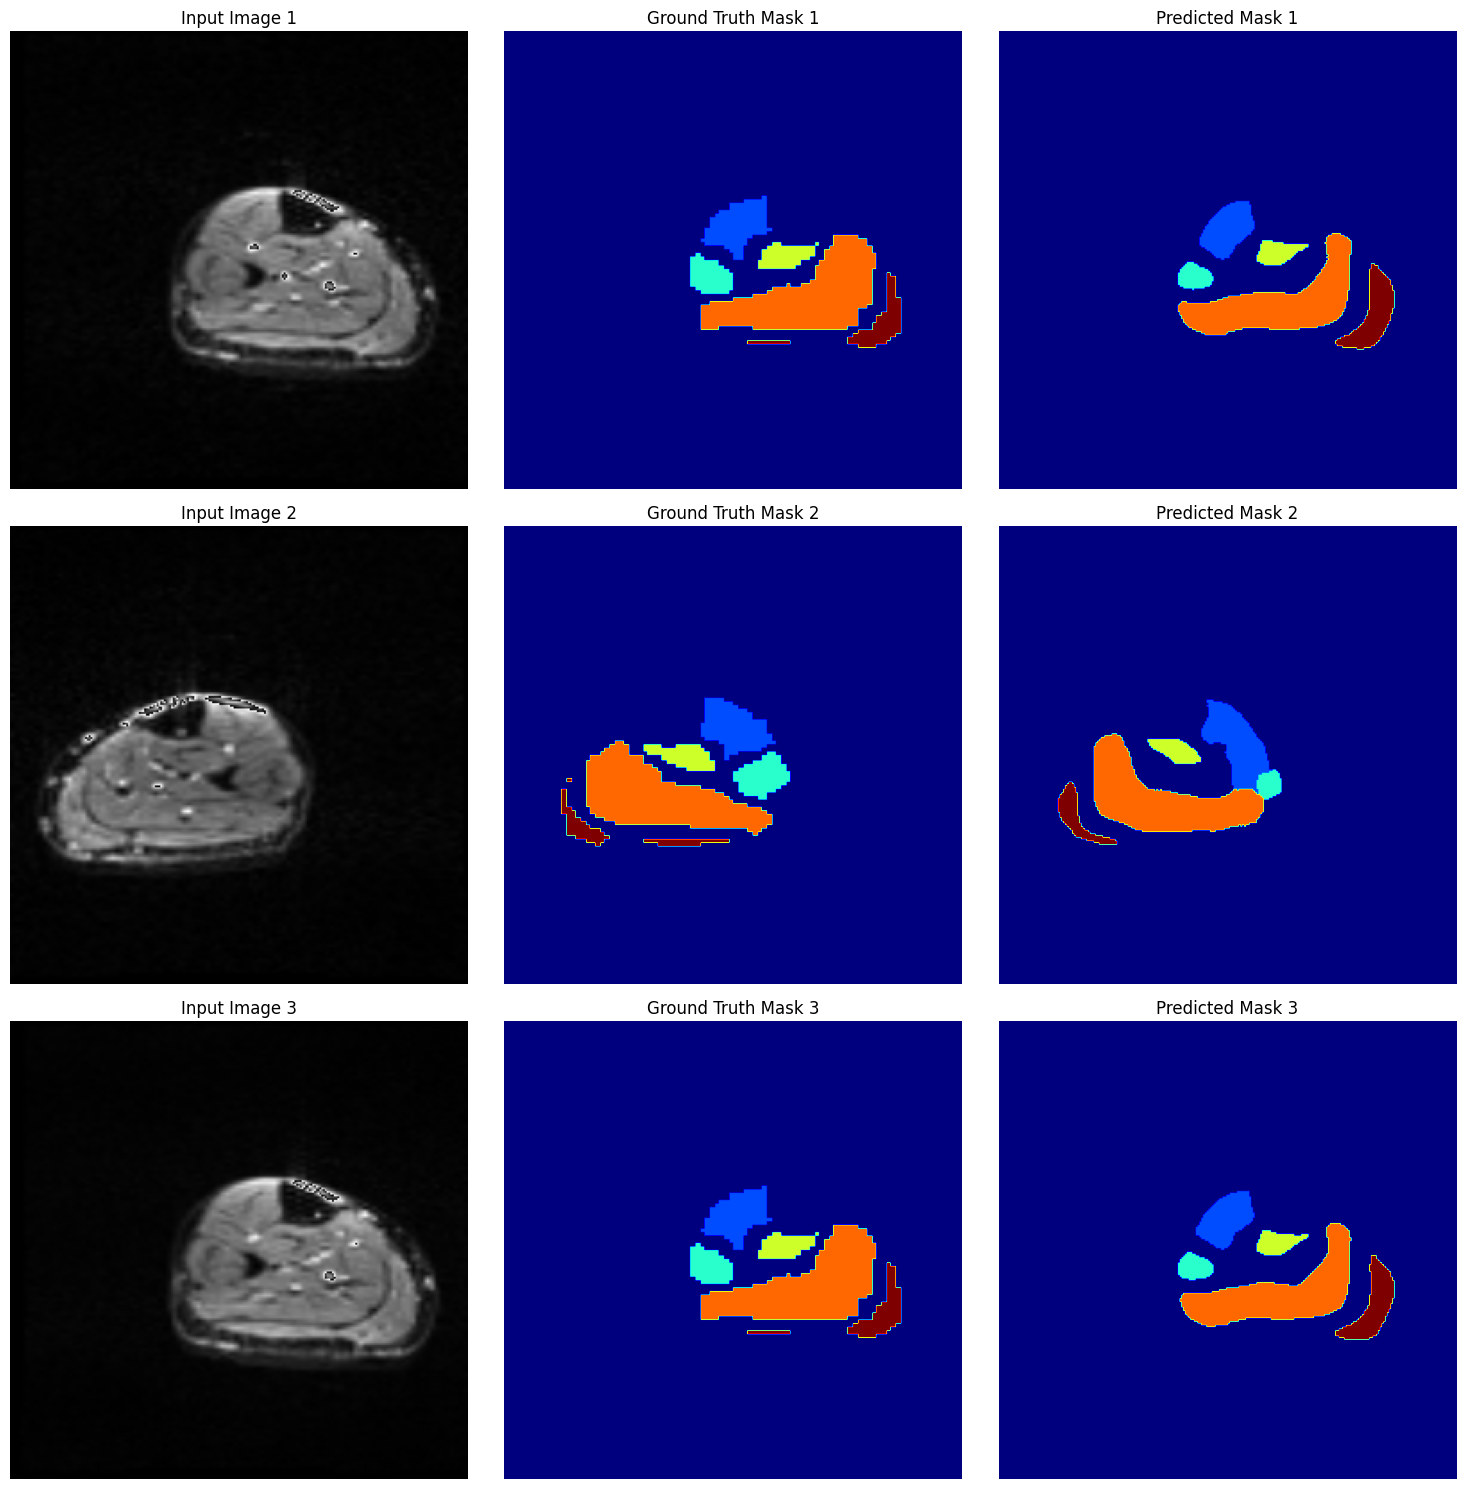

In [4]:
import tensorflow as tf
import numpy as np
import yaml
import logging
import os
from pathlib import Path
import matplotlib.pyplot as plt
from model import Generator  # Assuming this is a custom U-Net model

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler('evaluation.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

class SegmentationEvaluator:
    """A class to handle evaluation and visualization of a U-Net model on test data."""

    def __init__(self, config_path: str):
        """
        Initialize the evaluator with configuration from a YAML file.

        Args:
            config_path (str): Path to the YAML configuration file.
        """
        if not os.path.exists(config_path):
            logger.error(f"Configuration file not found at {config_path}")
            raise FileNotFoundError(f"Configuration file not found at {config_path}")
        self.config = self._load_config(config_path)
        self._validate_config()
        self.data_path = Path(self.config['data']['path'])
        self.model = None
        self.test_dataset = None
        self.setup_environment()

    def _load_config(self, config_path: str) -> dict:
        """Load and parse the YAML configuration file."""
        try:
            with open(config_path, 'r') as file:
                config = yaml.safe_load(file)
            logger.info(f"Loaded configuration from {config_path}")
            return config
        except Exception as e:
            logger.error(f"Failed to load config file {config_path}: {str(e)}")
            raise

    def _validate_config(self):
        """Validate the configuration parameters."""
        required_keys = [
            'data.path', 'data.batch_size',
            'model.img_width', 'model.img_height', 'model.input_channels', 'model.output_channels',
            'training.weights_path'
        ]
        for key in required_keys:
            if not self._get_nested_config(key):
                logger.error(f"Missing or invalid configuration key: {key}")
                raise ValueError(f"Configuration key {key} is missing or invalid")

    def _get_nested_config(self, key: str):
        """Access nested dictionary keys."""
        current = self.config
        for part in key.split('.'):
            current = current.get(part)
            if current is None:
                return None
        return current

    def setup_environment(self):
        """Set up the TensorFlow environment."""
        os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            logger.info(f"Using GPU: {gpus}")
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                logger.warning(f"GPU memory growth setup failed: {str(e)}")
        else:
            logger.info("No GPU found, using CPU.")

    def load_test_data(self):
        """Load and preprocess test dataset."""
        try:
            # Load test data
            test_data_x = np.load(self.data_path / 'test_images.npy')
            test_data_y = np.load(self.data_path / 'test_masks_hot_encoded.npy')

            # Reshape input data to add channel dimension if missing
            if len(test_data_x.shape) == 3:
                test_data_x = test_data_x[..., np.newaxis]  # Add channel dimension: (None, 256, 256) -> (None, 256, 256, 1)
                logger.info("Added channel dimension to test_data_x")

            # Validate test data shapes
            expected_shape_x = (None, self.config['model']['img_height'], self.config['model']['img_width'], self.config['model']['input_channels'])
            expected_shape_y = (None, self.config['model']['img_height'], self.config['model']['img_width'], self.config['model']['output_channels'])
            self._validate_data_shapes(test_data_x, test_data_y, expected_shape_x, expected_shape_y, 'test')

            # Create TensorFlow dataset
            with tf.device('/cpu:0'):
                test_data_x = tf.data.Dataset.from_tensor_slices(test_data_x)
                test_data_y = tf.data.Dataset.from_tensor_slices(test_data_y)
                self.test_dataset = tf.data.Dataset.zip((test_data_x, test_data_y))
                self.test_dataset = self.test_dataset.batch(self.config['data']['batch_size']).prefetch(tf.data.AUTOTUNE)

            logger.info("Test dataset loaded and preprocessed successfully.")
        except Exception as e:
            logger.error(f"Failed to load or preprocess test data: {str(e)}")
            raise

    def _validate_data_shapes(self, data_x, data_y, expected_shape_x, expected_shape_y, dataset_name: str):
        """Validate the shapes of input data."""
        if data_x.shape[1:] != expected_shape_x[1:]:
            logger.error(f"Invalid {dataset_name} input shape: got {data_x.shape}, expected {expected_shape_x}")
            raise ValueError(f"Invalid {dataset_name} input shape")
        if data_y.shape[1:] != expected_shape_y[1:]:
            logger.error(f"Invalid {dataset_name} label shape: got {data_y.shape}, expected {expected_shape_y}")
            raise ValueError(f"Invalid {dataset_name} label shape")

    def dice_coefficient(self, y_true, y_pred):
        """Compute Dice coefficient for model evaluation."""
        smooth = 1e-6
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
        union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return tf.reduce_mean(dice)

    def setup_model(self):
        """Initialize and compile the U-Net model."""
        try:
            self.model = Generator()
            weights_path = Path(self.config['training']['weights_path'])
            if weights_path.exists():
                self.model.load_weights(weights_path)
                logger.info(f"Loaded weights from {weights_path}")
            else:
                logger.error(f"Weights file {weights_path} not found")
                raise FileNotFoundError(f"Weights file {weights_path} not found")

            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(),
                loss=self.combined_loss,
                metrics=[self.dice_coefficient]
            )
            logger.info("Model compiled successfully.")
        except Exception as e:
            logger.error(f"Failed to set up model: {str(e)}")
            raise

    def combined_loss(self, y_true, y_pred):
        """Combined loss function: BCE + Dice."""
        alpha = self.config['training']['alpha']
        bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
        dice_loss = self.dice_loss_channel_wise(y_true, y_pred)
        return alpha * bce_loss + (1 - alpha) * dice_loss

    def dice_loss_channel_wise(self, y_true, y_pred, smooth=1e-6):
        """Compute channel-wise Dice loss for multi-class segmentation."""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true_f = tf.reshape(y_true, (-1, y_true.shape[-1]))
        y_pred_f = tf.reshape(y_pred, (-1, y_pred.shape[-1]))
        intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
        union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss_per_channel = 1 - dice
        return tf.reduce_mean(dice_loss_per_channel)

    def evaluate_and_visualize(self, num_samples_to_visualize=3):
        """Evaluate the model on test data and display results in a Jupyter Notebook."""
        try:
            self.load_test_data()
            self.setup_model()

            # Evaluate model on test data
            logger.info("Evaluating model on test data...")
            test_results = self.model.evaluate(self.test_dataset, return_dict=True)
            logger.info(f"Test results: {test_results}")

            # Generate predictions for visualization
            test_images, test_masks = next(iter(self.test_dataset.take(1)))  # Get one batch
            predictions = self.model.predict(test_images)

            # Convert predictions to class indices for visualization
            pred_masks = np.argmax(predictions, axis=-1)  # Shape: (batch_size, 256, 256)
            true_masks = np.argmax(test_masks, axis=-1)   # Shape: (batch_size, 256, 256)

            # Visualize results
            plt.figure(figsize=(15, 5 * num_samples_to_visualize))
            for i in range(min(num_samples_to_visualize, test_images.shape[0])):
                # Input image (grayscale)
                plt.subplot(num_samples_to_visualize, 3, i * 3 + 1)
                plt.imshow(test_images[i, :, :, 0], cmap='gray')
                plt.title(f'Input Image {i+1}')
                plt.axis('off')

                # Ground truth mask
                plt.subplot(num_samples_to_visualize, 3, i * 3 + 2)
                plt.imshow(true_masks[i], cmap='jet', vmin=0, vmax=self.config['model']['output_channels']-1)
                plt.title(f'Ground Truth Mask {i+1}')
                plt.axis('off')

                # Predicted mask
                plt.subplot(num_samples_to_visualize, 3, i * 3 + 3)
                plt.imshow(pred_masks[i], cmap='jet', vmin=0, vmax=self.config['model']['output_channels']-1)
                plt.title(f'Predicted Mask {i+1}')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

            return test_results
        except Exception as e:
            logger.error(f"Failed to evaluate test data: {str(e)}")
            raise

def main():
    """Main function to run the evaluation pipeline."""
    config_path = 'config.yaml'  # Update this to the correct path if needed
    evaluator = SegmentationEvaluator(config_path)
    test_results = evaluator.evaluate_and_visualize(num_samples_to_visualize=3)
    return test_results

if __name__ == '__main__':
    # Enable inline plotting for Jupyter Notebook
    %matplotlib inline
    test_results = main()

In [10]:
 predictions = model.predict(test_images)

NameError: name 'model' is not defined